In [1]:
import tensorflow as tf                  # TensorFlow
import tensorflow.nn as nn               # nn contains useful neural network functions like softmax, relu, tanh
from tensorflow import keras             # high level API for TensorFlow
import tensorflow.keras.layers as layers # contains layers like RNN, CNN, LSTM
import tensorflow.keras.losses as losses
from tensorflow.keras.models import Model

import numpy as np                       # standard numerical python
from sklearn.model_selection import train_test_split   # used to partition datasets
import math
import matplotlib.pyplot as plt

In [3]:
tf.config.list_physical_devices('GPU')  # if this returns empty enable GPU in collab

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Preparing the Data

To train any model we will need training (and validation) data. In TensorFlow, the best way to do this is by creating an instance of the tf.data.Dataset that contains our data. This tf.data.Dataset object can then be used to train the model during training time. 

Specifically, we want to create this dataset from the numpy datat. So we will start by just loading the data

Now we want to create a data loader from the available datasets. For this we are going to load the data into a TensorFlow object from the NumPy data. 

### Load and Format the Data

In [4]:
# load in the NumPy arrays containing data

# T0 = 0; T1 = 500 is qualitatively good considering the data
# T0 = 0; T1 = 400; STEP = 5 is pretty good
# T0 = 50; T1 = 450; STEP = 5 works well too
T0 = 0
T1 = 500
STEP = 5
T = math.ceil((T1 - T0) / STEP)

X_test_np = np.load("X_test.npy")[:, :, T0:T1]
y_test_np = np.load("y_test.npy")
person_test = np.load("person_test.npy").flatten()

X_train_valid_np = np.load("X_train_valid.npy")[:, :, T0:T1]
y_train_valid_np = np.load("y_train_valid.npy")
person_train_valid = np.load("person_train_valid.npy").flatten()

# X_train_valid_np = X_train_valid_np[person_train_valid == 0]
# y_train_valid_np = y_train_valid_np[person_train_valid == 0]
# X_test_np = X_test_np[person_test == 0]
# y_test_np = y_test_np[person_test == 0]

print("training data:", X_train_valid_np.shape)
print("testing data:", X_test_np.shape)

training data: (2115, 22, 500)
testing data: (443, 22, 500)


### Assign labels to the data

In [5]:
# re-assign labels to be between 0 and 3
y_train_valid_np[y_train_valid_np==769] = 0  # cue onset left
y_train_valid_np[y_train_valid_np==770] = 1  # cue onset right
y_train_valid_np[y_train_valid_np==771] = 2  # cue onset foot
y_train_valid_np[y_train_valid_np==772] = 3  # cue onset tongue

y_test_np[y_test_np==769] = 0  # cue onset left
y_test_np[y_test_np==770] = 1  # cue onset right
y_test_np[y_test_np==771] = 2  # cue onset foot
y_test_np[y_test_np==772] = 3  # cue onset tongue

### Split the training/validation data

In [8]:
def augment_data(X, y):
    X_avg = X.reshape((X.shape[0], X.shape[1], -1, STEP)).mean(axis=3)
    X_avg += np.random.normal(0, 0.5, X_avg.shape)
    X_max = X.reshape((X.shape[0], X.shape[1], -1, STEP)).max(axis=3)
    X_steps = X[:,:,::STEP]
    y_steps = y
    for i in range(1, STEP):
        X_steps = np.vstack((X_steps, X[:,:,i::STEP]))
        y_steps = np.hstack((y_steps, y))
    X_augmented = np.vstack((X_avg, X_max, X_steps))
    y_augmented = np.hstack((y_steps, y, y))
    return X_augmented, y_augmented

In [9]:
X_train_np, X_valid_np, y_train_np, y_valid_np = train_test_split(X_train_valid_np, y_train_valid_np, test_size=0.2, random_state=12345)

# Augment training dataset
X_train_np, y_train_np = augment_data(X_train_np, y_train_np)

# Augment validation dataset
X_valid_np, y_valid_np = augment_data(X_valid_np, y_valid_np)

# model expects (batch, seq, features) but currently we have (batch, features, seq)
X_train_np = X_train_np.transpose((0, 2, 1))
X_valid_np = X_valid_np.transpose((0, 2, 1))

### Create grayscale images for CNN training

In [10]:
# add extra dimension for grayscale images
X_train_np_grayscale = np.expand_dims(X_train_np, axis=-1)
X_valid_np_grayscale = np.expand_dims(X_valid_np, axis=-1)
# X_test_np_grayscale = np.expand_dims(X_test_np, axis=-1)

print("training images:", X_train_np_grayscale.shape)
print("training labels:", y_train_np.shape)
print("validation images:", X_valid_np_grayscale.shape)
print("validation labels:", y_valid_np.shape)
# print("test images:", X_test_np_grayscale.shape)
# print("test labels:", y_test_np.shape)

training images: (11844, 100, 22, 1)
training labels: (11844,)
validation images: (2961, 100, 22, 1)
validation labels: (2961,)


### Create tf.data.Dataset objects for the data

for more info see: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [11]:
# construct the dataset from the NumPy arrays
X_train_grayscale = tf.data.Dataset.from_tensor_slices((X_train_np_grayscale, y_train_np))
X_valid_grayscale = tf.data.Dataset.from_tensor_slices((X_valid_np_grayscale, y_valid_np))
# X_test_grayscale = tf.data.Dataset.from_tensor_slices((X_test_np_grayscale, y_test_np))

# batch and shuffle
X_train_grayscale = X_train_grayscale.shuffle(1024).batch(64)
X_valid_grayscale = X_valid_grayscale.shuffle(1024).batch(64)
# X_test_grayscale = X_test_grayscale.shuffle(1024).batch(64)

In [12]:
# construct the dataset from the NumPy arrays
X_train = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
X_valid = tf.data.Dataset.from_tensor_slices((X_valid_np, y_valid_np))
# X_test = tf.data.Dataset.from_tensor_slices((X_test_np, y_test_np))

# batch and shuffle
X_train = X_train.shuffle(1024).batch(64)
X_valid = X_valid.shuffle(1024).batch(64)
# X_test = X_test.shuffle(1024).batch(64)

In [13]:
print(X_train)
print(X_valid)
# print(X_test)

<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Visualize the data

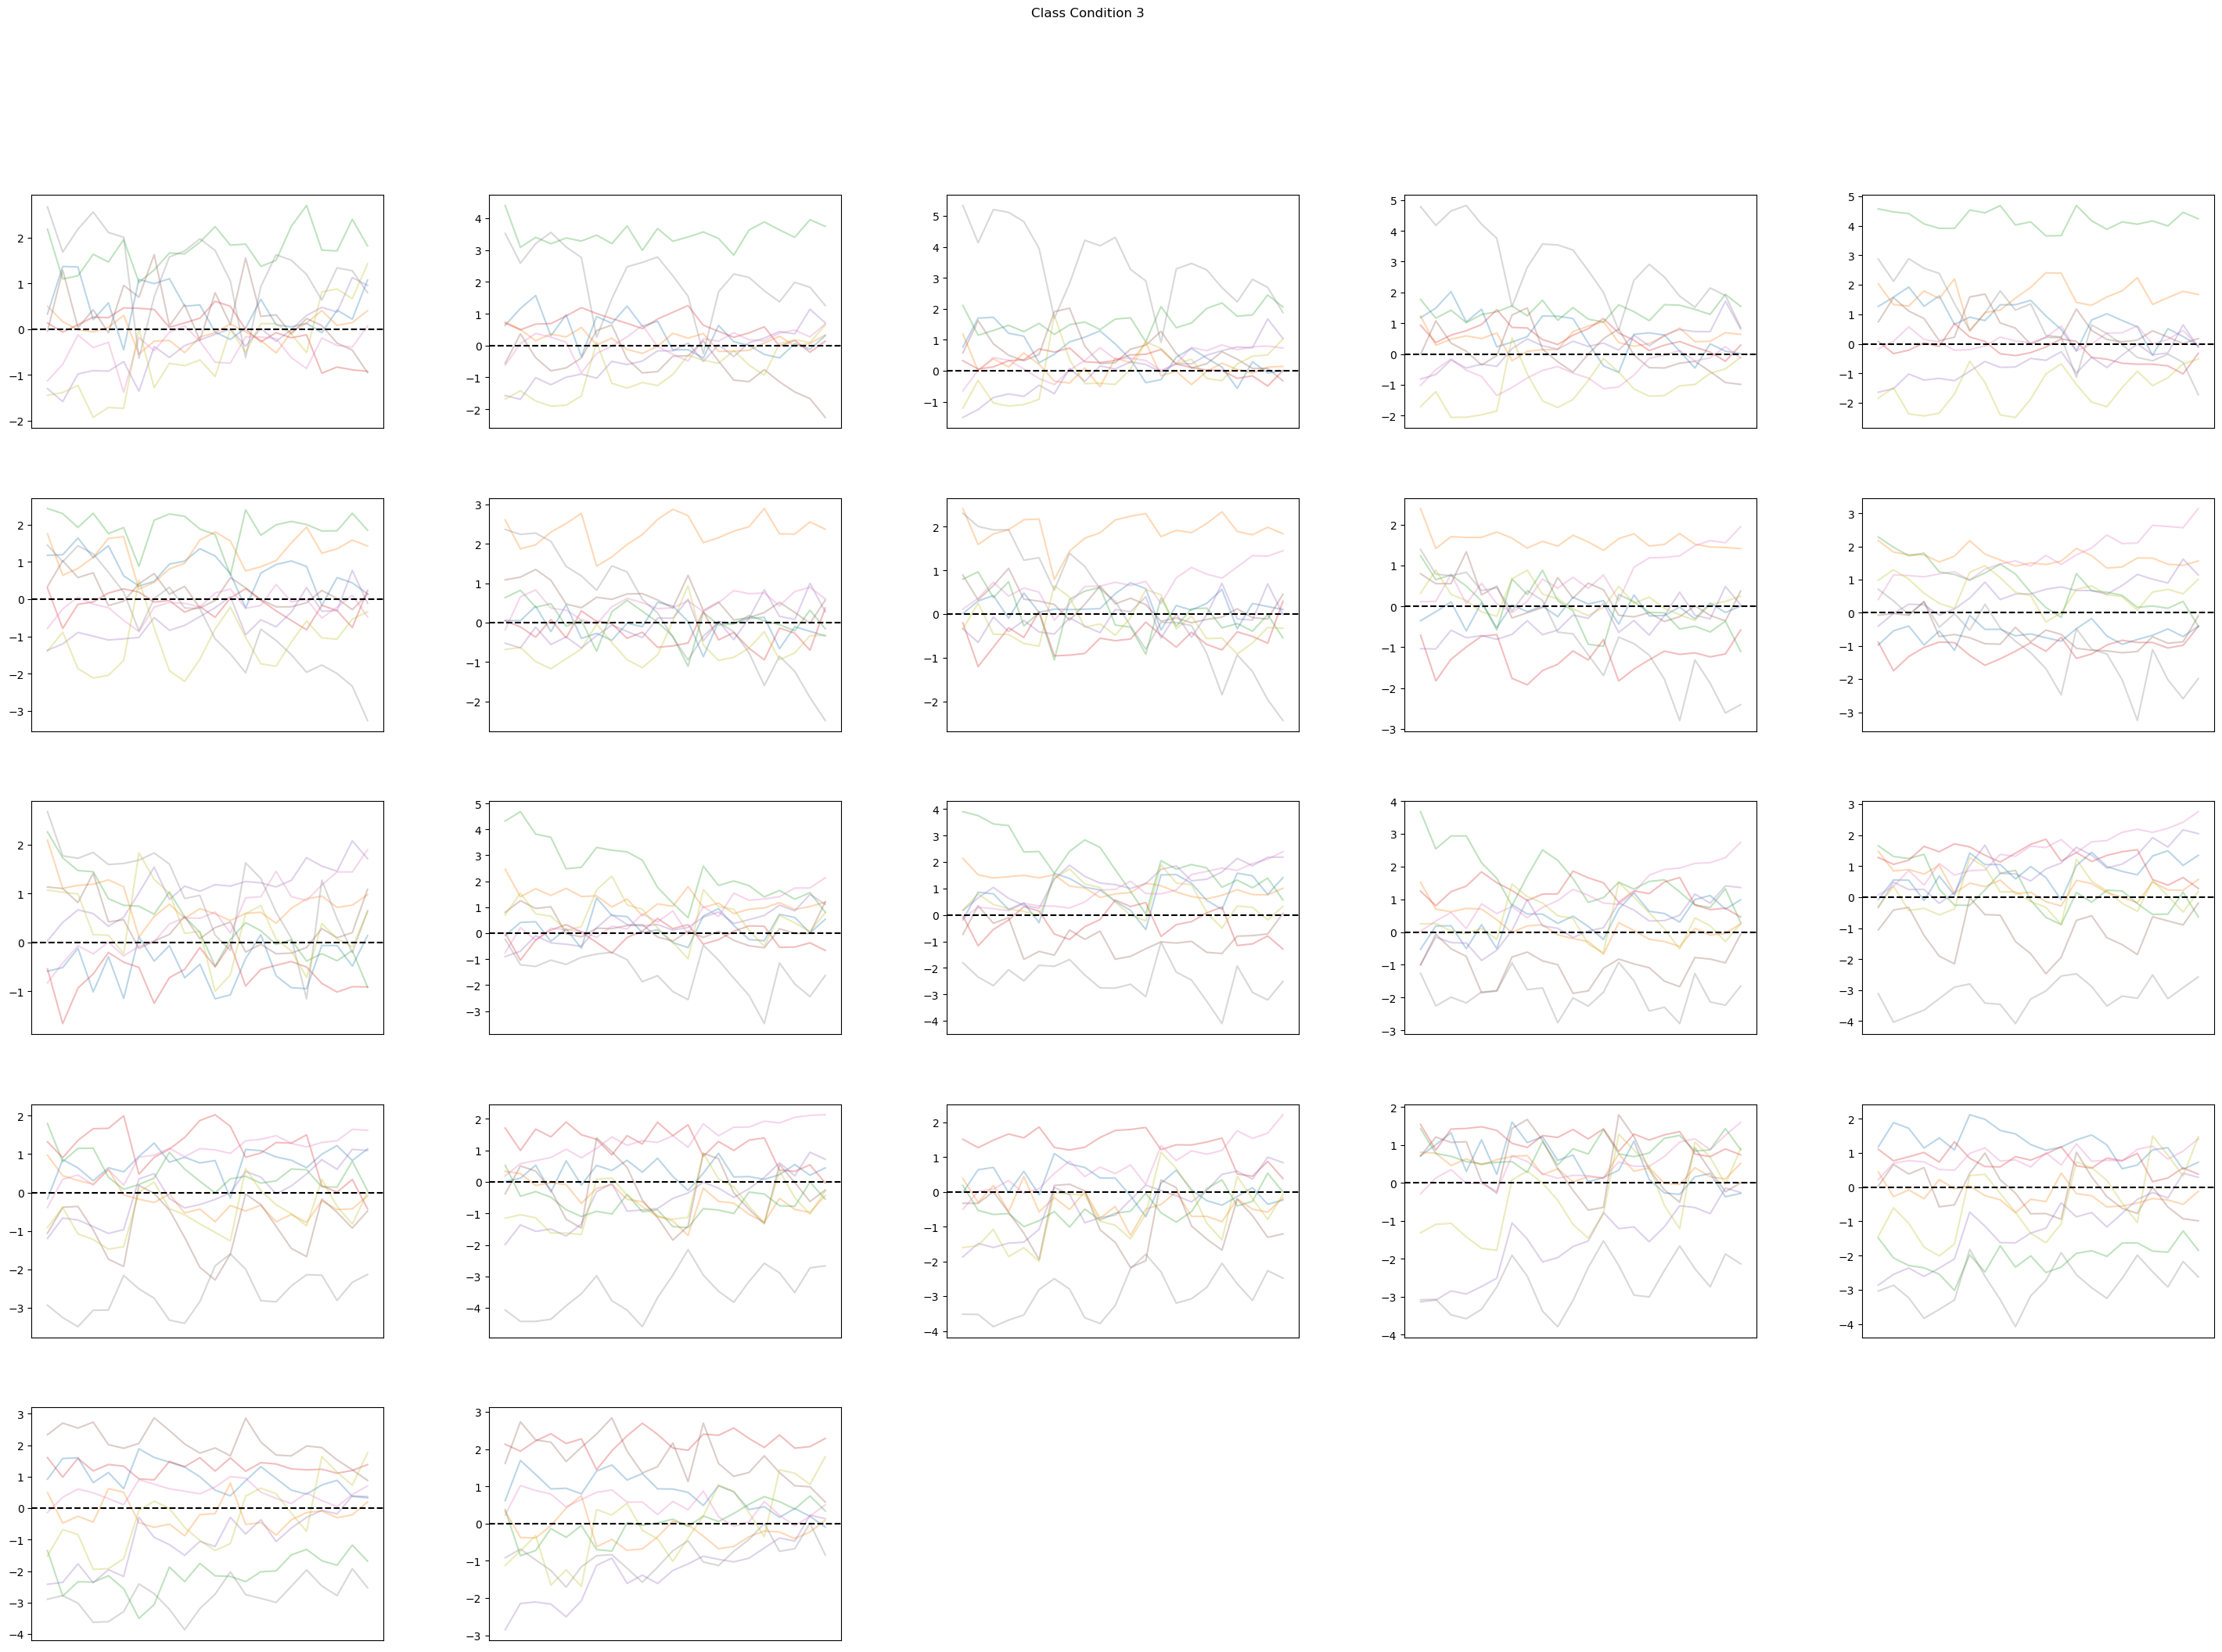

In [213]:
c = 3

fig = plt.figure(figsize=(36, 24))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
rows, cols = 5, 5

X_class_data = X_train_valid_np[y_train_valid_np == c]
person_class_data = person_train_valid[y_train_valid_np == c]

for i in range(22):
    ax = fig.add_subplot(rows, cols, i+1)
    for p in range(9):
        ax.plot(X_class_data[person_class_data == p][:,:,i].mean(axis=0), alpha=0.3)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.axhline(0, linestyle='--', c='black')

fig.suptitle(f'Class Condition {c}')
plt.show()

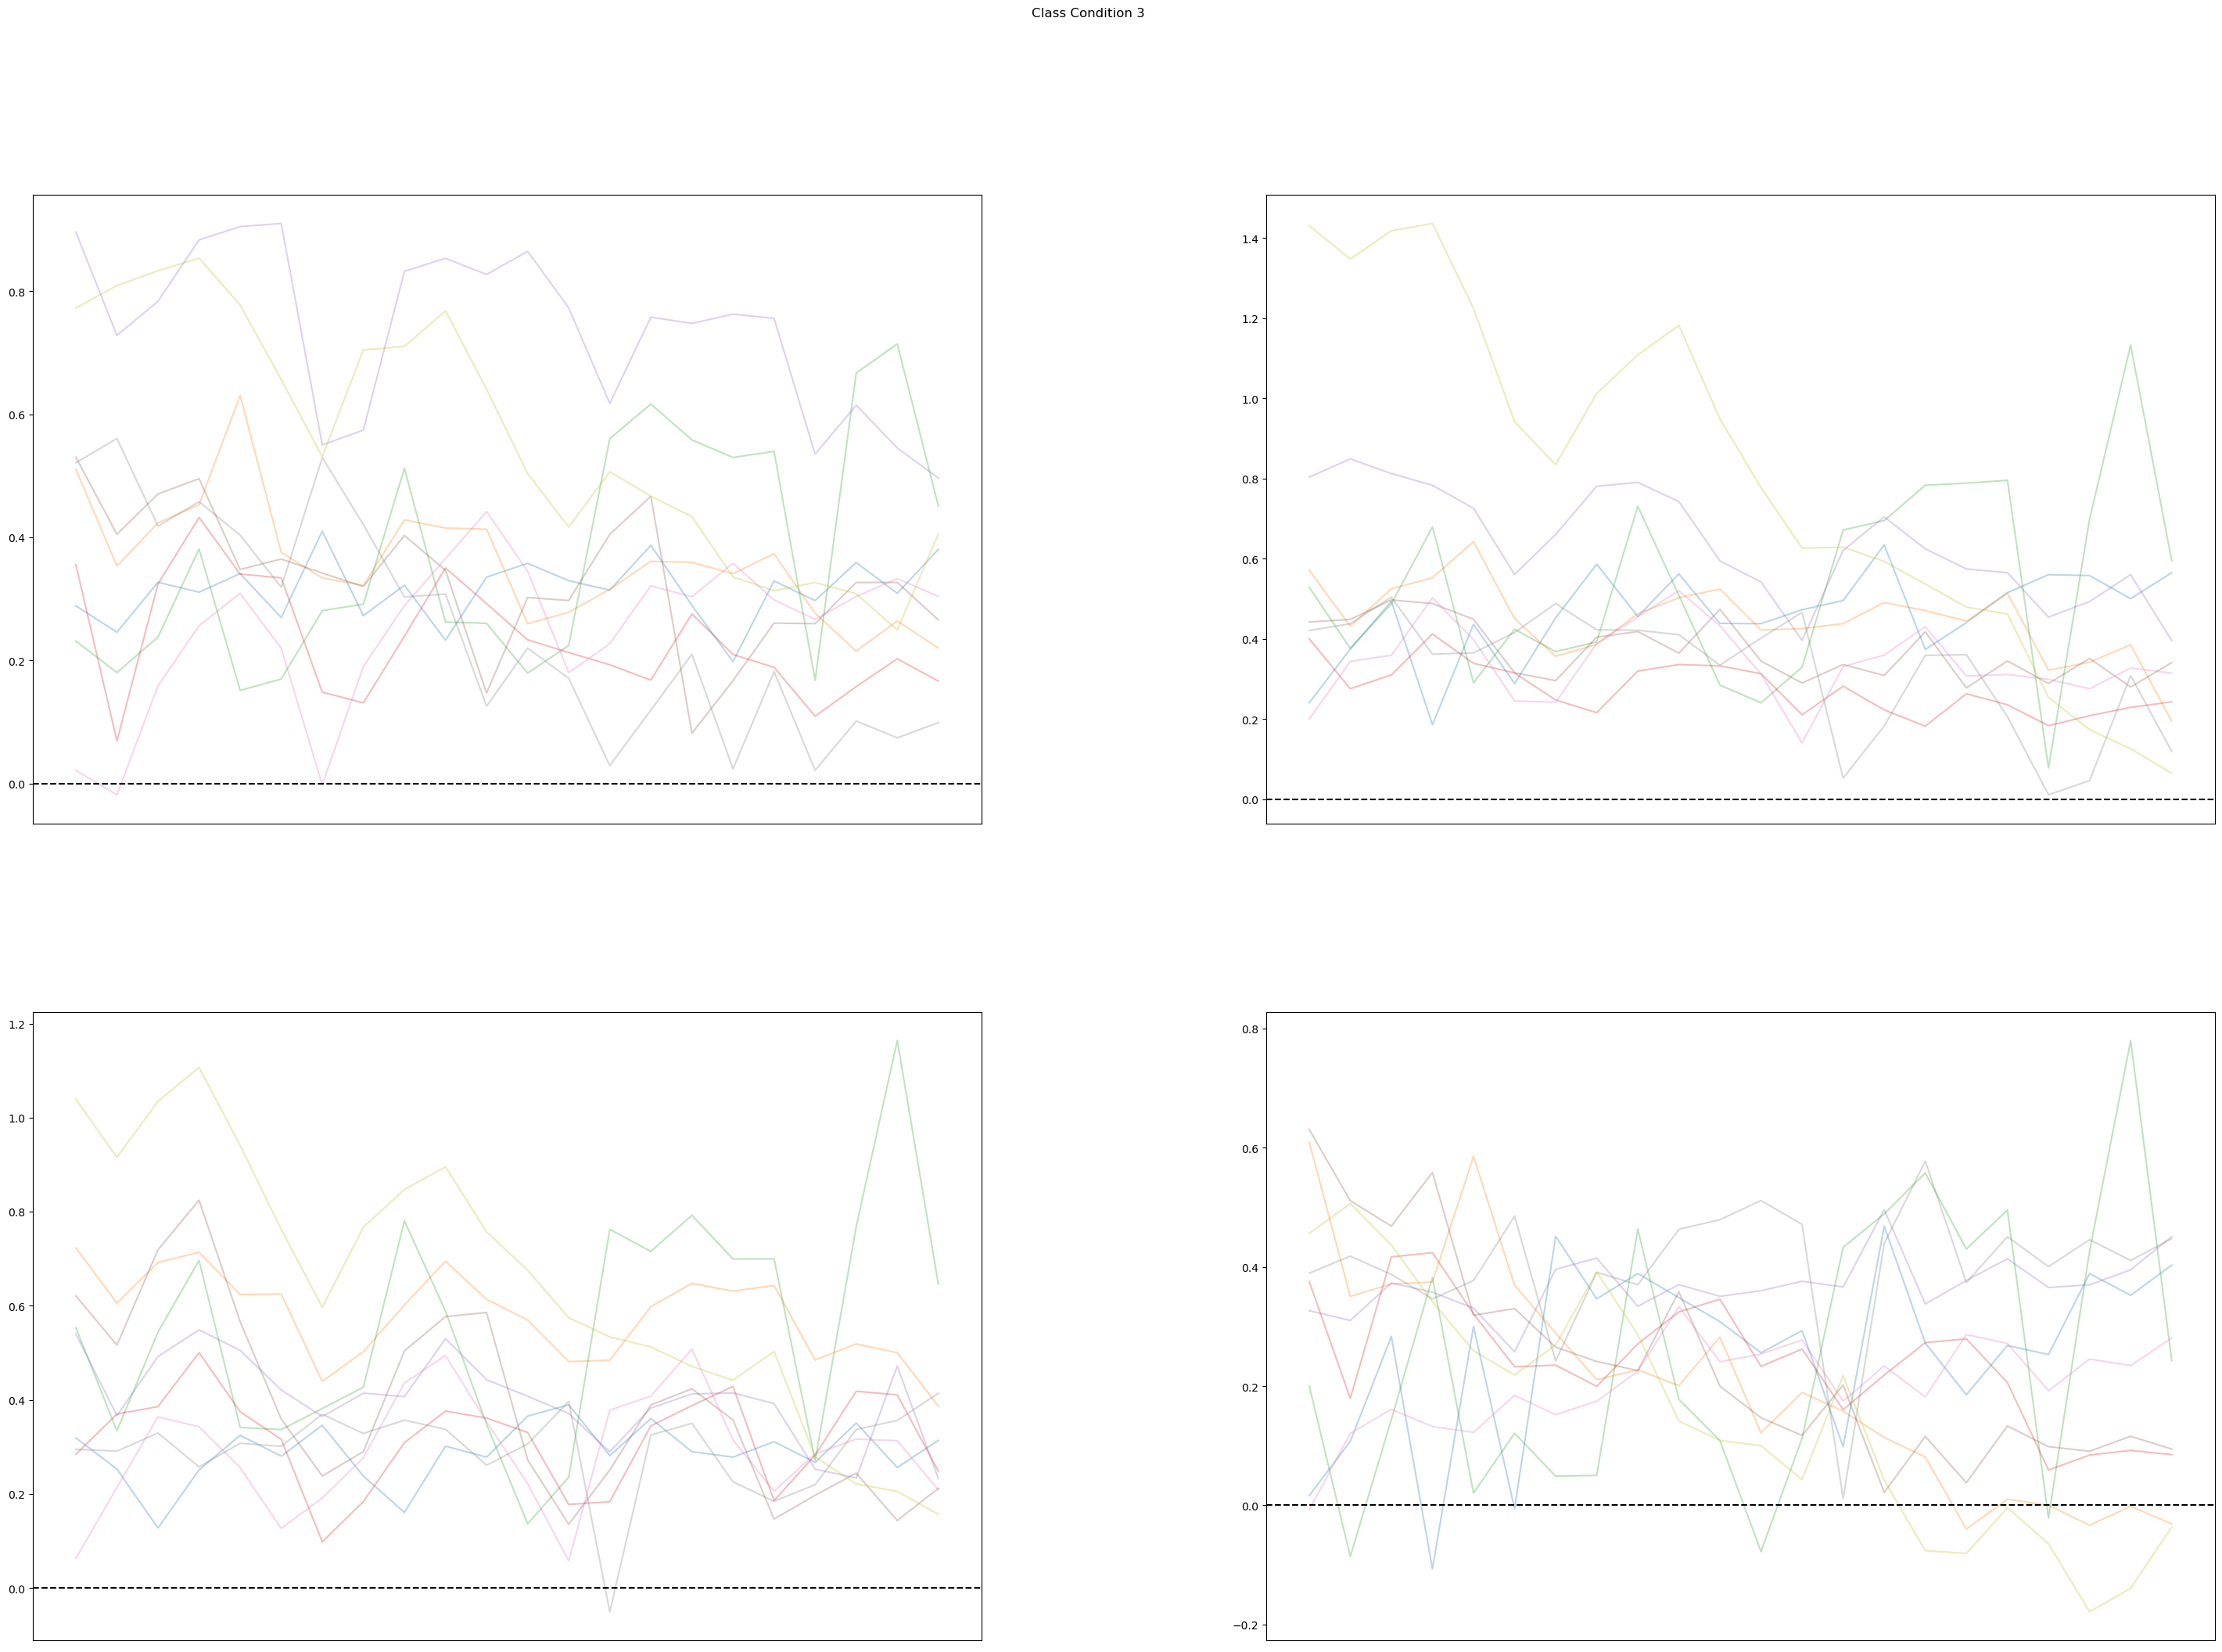

In [214]:
fig = plt.figure(figsize=(36, 24))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
rows, cols = 2, 2

for c in range(4):
    ax = fig.add_subplot(rows, cols, c+1)
    X_class_data = X_train_valid_np[y_train_valid_np == c]
    person_class_data = person_train_valid[y_train_valid_np == c]
    for p in range(9):
        ax.plot(X_class_data[person_class_data == p].mean(axis=(0,2)), alpha=0.3)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.axhline(0, linestyle='--', c='black')

fig.suptitle(f'Class Condition {c}')
plt.show()

# Creating A Recurrent Neural Network Model

In [14]:
def score_augmented(model, X_test):
    p = model.predict(X_test[:,:,::STEP].transpose((0, 2, 1)), verbose=False)
    for i in range(1, STEP):
        p += model.predict(X_test[:,:,i::STEP].transpose((0, 2, 1)), verbose=False)

    p += model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], -1, STEP)).mean(axis=3).transpose((0, 2, 1)), verbose=False)
    p += model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], -1, STEP)).max(axis=3).transpose((0, 2, 1)), verbose=False)
    p /= (STEP + 2)
    
    return p

In [37]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = keras.Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(layers.Reshape((T,1,22), input_shape=(T,22)))
hybrid_cnn_lstm_model.add(layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(layers.BatchNormalization())
hybrid_cnn_lstm_model.add(layers.Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(layers.BatchNormalization())
hybrid_cnn_lstm_model.add(layers.Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(layers.BatchNormalization())
hybrid_cnn_lstm_model.add(layers.Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(layers.Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(layers.MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(layers.BatchNormalization())
hybrid_cnn_lstm_model.add(layers.Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(layers.Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(layers.Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(layers.Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(layers.LSTM(10, dropout=0.6, input_shape=(100,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(layers.Dense(4, activation='softmax')) # Output FC layer with softmax activation

loss_fn = keras.losses.SparseCategoricalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-4)
hybrid_cnn_lstm_model.compile(optimizer=opt, loss=loss_fn, metrics='accuracy')

# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 80, 1, 22)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 80, 1, 25)         5525      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 27, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_16 (Bat  (None, 27, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 27, 1, 25)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 1, 50)        

In [15]:
# Adapted from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9028677/
def create_model():
    clf = keras.Sequential([
        layers.Input((T, 22)),
        layers.Dense(128, activation="relu", name='linear'),

        layers.Conv1D(64, kernel_size=3, activation="relu", padding="same", name="conv-1"),
        layers.MaxPool1D(pool_size=2, padding="same"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Conv1D(128, kernel_size=5, activation="relu", padding="same", name="conv-2"),
        layers.MaxPool1D(pool_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Bidirectional(layers.LSTM(32, return_sequences=False, name="lstm-1")),
        layers.Dropout(0.5),

        layers.Dense(4, activation=nn.softmax, name="class-probs")
    ])

    loss_fn = keras.losses.SparseCategoricalCrossentropy()
    opt = keras.optimizers.Adam(
        learning_rate=1e-3,
        weight_decay=None
    )
    clf.compile(optimizer=opt, loss=loss_fn, metrics='accuracy')
    
    return clf

rnn_clf = create_model()
rnn_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear (Dense)              (None, 100, 128)          2944      
                                                                 
 conv-1 (Conv1D)             (None, 100, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 64)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 50, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 50, 64)            0         
                                                                 
 conv-2 (Conv1D)             (None, 50, 128)           4

In [201]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
history = rnn_clf.fit(x=X_train, validation_data=X_valid, epochs=250,
                      callbacks=[early_stop])

Epoch 1/250
186/186 [==============================] - 9s 18ms/step - loss: 1.4045 - accuracy: 0.2863 - val_loss: 1.3362 - val_accuracy: 0.3509
Epoch 2/250
186/186 [==============================] - 2s 12ms/step - loss: 1.3253 - accuracy: 0.3538 - val_loss: 1.2912 - val_accuracy: 0.4120
Epoch 3/250
186/186 [==============================] - 2s 13ms/step - loss: 1.2360 - accuracy: 0.4352 - val_loss: 1.2326 - val_accuracy: 0.4090
Epoch 4/250
186/186 [==============================] - 2s 12ms/step - loss: 1.1492 - accuracy: 0.4981 - val_loss: 1.1028 - val_accuracy: 0.5518
Epoch 5/250
186/186 [==============================] - 3s 17ms/step - loss: 1.0588 - accuracy: 0.5490 - val_loss: 1.1527 - val_accuracy: 0.5167
Epoch 6/250
186/186 [==============================] - 2s 13ms/step - loss: 0.9948 - accuracy: 0.5862 - val_loss: 1.0397 - val_accuracy: 0.5718
Epoch 7/250
186/186 [==============================] - 2s 12ms/step - loss: 0.9178 - accuracy: 0.6328 - val_loss: 1.0087 - val_accuracy:

In [202]:
# For each test sample, we take the average of the predictions on its augmented set
p = score_augmented(rnn_clf, X_test_np)
y_pred = p.argmax(axis=1)
print(f"Test accuracy: {np.sum(y_pred == y_test_np) / len(y_pred)}")

Test accuracy: 0.672686230248307


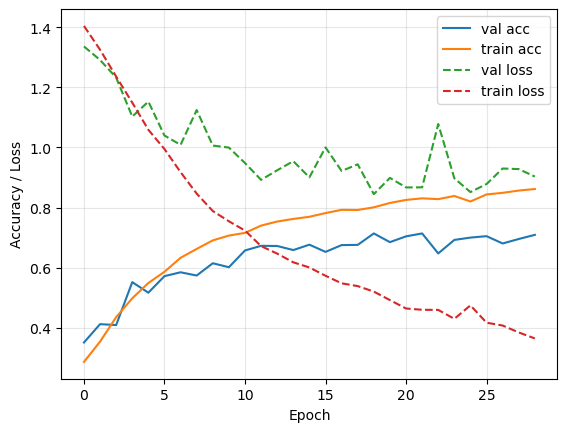

In [21]:
plt.plot(np.arange(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='val acc')
plt.plot(np.arange(len(history.history['accuracy'])), history.history['accuracy'], label='train acc')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], linestyle='--', label='val loss')
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], linestyle='--', label='train loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [203]:
rnn_clf.save_weights('/kaggle/working/conv2-lstm2-1')

## Ensembling multiple models

In [210]:
model_paths = ['conv2-lstm2-67', 'conv2-lstm2-67-2']
p_ensemble = np.zeros((y_test_np.shape[0], 4), dtype=np.float64)

model_base_path = '/kaggle/working/'
for model_path in model_paths:
    rnn_clf = create_model()
    rnn_clf.load_weights(f'{model_base_path}{model_path}')
    p_ensemble += score_augmented(rnn_clf, X_test_np)

y_pred_ensemble = np.argmax(p_ensemble, axis=1)
print(f"Test accuracy: {np.sum(y_pred_ensemble == y_test_np) / len(y_pred)}")

Test accuracy: 0.7065462753950339
